In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
df=pd.read_csv('D:\Inteligencia artifical\Modelo IA Resistencia semento\CPN50_cement_composition_strength.csv')
df.head()

,Unnamed: 0,date,ric,nat,pl,em,ml,rie,g75µ,g45µ,...,r91_iram1622,pf,so3,mgo,sio2,fe2o3,caot,al2o3,na2o,k2o
0,0,2018-01-02,7707ST,AC,3,LML,3,7707ST,0.34,4.22,...,NaN,1.83,2.89,0.99,22.16,4.60,60.98,4.86,0.10,1.14
1,1,2018-01-02,7702ST,AC,2,LML,2,7702ST,0.68,4.45,...,NaN,1.58,2.88,0.71,22.62,4.08,61.09,4.58,0.13,1.01
2,2,2018-01-05,7722ST,AC,2,LML,2,7722ST,0.68,4.45,...,NaN,1.83,2.90,0.90,22.76,4.49,61.90,4.69,0.12,1.02
3,3,2018-01-07,7726ST,AC,3,LML,3,7726ST,0.81,4.59,...,NaN,1.97,2.84,0.72,22.45,4.08,61.75,4.57,0.12,1.02
4,4,2018-01-08,7729ST,AC,2,LML,2,7729ST,0.38,3.46,...,NaN,2.01,2.85,0.69,22.67,4.16,61.07,4.64,0.13,1.04


In [5]:
# Definir columnas de entrada y salida
material_columns = ['pf', 'so3', 'mgo', 'sio2', 'fe2o3', 'caot', 'al2o3', 'na2o', 'k2o']
resistance_columns = ['r1_iram1622', 'r2_iram1622', 'r3_iram1622', 'r7_iram1622', 'r28_iram1622']

# Diccionario para almacenar datasets filtrados
datasets_por_resistencia = {}
df = df.dropna(subset=material_columns)
for col in resistance_columns:
    # Filtrar solo las filas donde la columna `col` no sea nula
    df_filtrado = df.dropna(subset=[col])
    
    # Separar X (características) y y (etiqueta específica)
    X_filtrado = df_filtrado[material_columns]
    y_filtrado = df_filtrado[col]  # Solo esta columna como etiqueta
    
    # Guardar en el diccionario
    datasets_por_resistencia[col] = (X_filtrado, y_filtrado)
    
    # Mostrar cuántas filas quedaron después del filtrado
    print(f"{col}: {X_filtrado.shape[0]} muestras disponibles después del filtrado")
    


r1_iram1622: 397 muestras disponibles después del filtrado
r2_iram1622: 944 muestras disponibles después del filtrado
r3_iram1622: 137 muestras disponibles después del filtrado
r7_iram1622: 785 muestras disponibles después del filtrado
r28_iram1622: 987 muestras disponibles después del filtrado


In [25]:
# Crear un dataframe con los valores reales de resistencia y materiales
df_reales = df[material_columns + resistance_columns]

# Ruta donde se guardará el archivo CSV
ruta_guardado = r"D:\Inteligencia artifical\Modelo IA Resistencia semento\modelos_guardados\valores_reales.csv"

# Guardar en un archivo CSV
df_reales.to_csv(ruta_guardado, index=False)

print(f"Archivo guardado con éxito en: {ruta_guardado}")


Archivo guardado con éxito en: D:\Inteligencia artifical\Modelo IA Resistencia semento\modelos_guardados\valores_reales.csv


In [6]:
# 🔹 Imputar valores nulos en materiales (X) con la mediana
imputer_X = SimpleImputer(strategy="median")
df[material_columns] = imputer_X.fit_transform(df[material_columns])

# 🔹 Hiperparámetros a probar en cada modelo
param_grid = {
    "RandomForest": {
        "n_estimators": [100, 300, 500], 
        "max_depth": [5, 10, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 3, 5]
    },
    "XGBoost": {
        "n_estimators": [100, 300, 500], 
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.3]
    },
    "CatBoost": {
        "n_estimators": [100, 300, 500], 
        "max_depth": [5, 10, 15],
        "learning_rate": [0.01, 0.1, 0.3]
    }
}

# Diccionario para almacenar el mejor modelo de cada resistencia
mejores_modelos = {}

for col in resistance_columns:
    print(f"\n🔍 Buscando el mejor modelo para {col}...\n")

    # Filtrar datos eliminando filas donde la resistencia tenga NaN
    df_filtrado = df.dropna(subset=[col])

    X = df_filtrado[material_columns]
    y = df_filtrado[col]

    # Dividir en conjunto de entrenamiento y prueba (80% - 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 🔹 Escalar los datos (opcional, más útil para XGBoost y CatBoost)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    mejor_mae = float("inf")
    mejor_modelo = None
    mejores_metricas = {}

    for nombre, param in param_grid.items():
        print(f"🔎 Probando {nombre} con GridSearchCV...")

        # Seleccionar modelo
        if nombre == "RandomForest":
            modelo = RandomForestRegressor(random_state=42)
        elif nombre == "XGBoost":
            modelo = XGBRegressor(random_state=42)
        elif nombre == "CatBoost":
            modelo = CatBoostRegressor(verbose=0, random_state=42)

        # Aplicar GridSearchCV para encontrar los mejores parámetros
        grid_search = GridSearchCV(modelo, param, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        # Obtener el mejor modelo con los mejores hiperparámetros
        mejor_modelo_temp = grid_search.best_estimator_
        mejores_parametros = grid_search.best_params_

        # Hacer predicciones con el mejor modelo encontrado
        y_pred = mejor_modelo_temp.predict(X_test_scaled)

        # Calcular métricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"✅ {nombre} Mejorado: MAE = {mae:.2f}, RMSE = {rmse:.2f} con {mejores_parametros}")

        # Guardar el mejor modelo según MAE
        if mae < mejor_mae:
            mejor_mae = mae
            mejor_modelo = mejor_modelo_temp
            mejores_metricas = {"MAE": mae, "RMSE": rmse, "Hiperparámetros": mejores_parametros}

    # Guardar el mejor modelo para esta resistencia
    mejores_modelos[col] = {"modelo": mejor_modelo, "metricas": mejores_metricas}

    print(f"\n🏆 Mejor modelo para {col}: {mejor_modelo.__class__.__name__} con MAE = {mejor_mae:.2f}\n")

# Mostrar los mejores modelos seleccionados
print("\n🎯 Mejores modelos por resistencia:")
for col, data in mejores_modelos.items():
    print(f"{col}: {data['modelo'].__class__.__name__} (MAE = {data['metricas']['MAE']:.2f}, RMSE = {data['metricas']['RMSE']:.2f})")


🔍 Buscando el mejor modelo para r1_iram1622...

🔎 Probando RandomForest con GridSearchCV...
✅ RandomForest Mejorado: MAE = 1.66, RMSE = 2.59 con {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
🔎 Probando XGBoost con GridSearchCV...
✅ XGBoost Mejorado: MAE = 1.69, RMSE = 2.63 con {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
🔎 Probando CatBoost con GridSearchCV...
✅ CatBoost Mejorado: MAE = 1.70, RMSE = 2.60 con {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100}

🏆 Mejor modelo para r1_iram1622: RandomForestRegressor con MAE = 1.66


🔍 Buscando el mejor modelo para r2_iram1622...

🔎 Probando RandomForest con GridSearchCV...
✅ RandomForest Mejorado: MAE = 1.49, RMSE = 1.88 con {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
🔎 Probando XGBoost con GridSearchCV...
✅ XGBoost Mejorado: MAE = 1.53, RMSE = 1.92 con {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
🔎 Probando CatBoos

d:\Inteligencia artifical\Modelo IA Resistencia semento\env_ia\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ CatBoost Mejorado: MAE = 1.75, RMSE = 2.19 con {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

🏆 Mejor modelo para r7_iram1622: CatBoostRegressor con MAE = 1.75


🔍 Buscando el mejor modelo para r28_iram1622...

🔎 Probando RandomForest con GridSearchCV...
✅ RandomForest Mejorado: MAE = 1.46, RMSE = 1.83 con {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
🔎 Probando XGBoost con GridSearchCV...
✅ XGBoost Mejorado: MAE = 1.53, RMSE = 1.89 con {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
🔎 Probando CatBoost con GridSearchCV...


d:\Inteligencia artifical\Modelo IA Resistencia semento\env_ia\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ CatBoost Mejorado: MAE = 1.42, RMSE = 1.81 con {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

🏆 Mejor modelo para r28_iram1622: CatBoostRegressor con MAE = 1.42


🎯 Mejores modelos por resistencia:
r1_iram1622: RandomForestRegressor (MAE = 1.66, RMSE = 2.59)
r2_iram1622: RandomForestRegressor (MAE = 1.49, RMSE = 1.88)
r3_iram1622: RandomForestRegressor (MAE = 2.16, RMSE = 3.05)
r7_iram1622: CatBoostRegressor (MAE = 1.75, RMSE = 2.19)
r28_iram1622: CatBoostRegressor (MAE = 1.42, RMSE = 1.81)


In [31]:
import matplotlib.pyplot as plt
import os

# Crear la carpeta si no existe
carpeta = "graficos del modelo"
if not os.path.exists(carpeta):
    os.makedirs(carpeta)

# 🔹 Graficar los resultados del mejor modelo para cada resistencia
for col, data in mejores_modelos.items():
    modelo = data["modelo"]

    # Filtrar datos eliminando NaN en la columna actual
    df_filtrado = df.dropna(subset=[col])
    X = df_filtrado[material_columns]
    y_real = df_filtrado[col]

    # Escalar con el mismo StandardScaler usado en el entrenamiento
    X_scaled = scaler.transform(X)

    # Obtener predicciones del modelo
    y_pred = modelo.predict(X_scaled)

    # 🔹 Gráfico de dispersión
    plt.figure(figsize=(7, 5))
    plt.scatter(y_real, y_pred, alpha=0.5, label="Predicciones", color="blue")
    plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], color="red", linestyle="--", label="Línea Ideal (y=x)")
    plt.xlabel("Valores Reales")
    plt.ylabel("Valores Predichos")
    plt.title(f"Comparación de Predicciones para {col}")
    plt.legend()
    plt.grid(True)

    # 📌 Guardar cada imagen con su nombre correspondiente
    ruta_imagen = os.path.join(carpeta, f"grafico_dispersion{col}.png")
    plt.savefig(ruta_imagen, dpi=300, bbox_inches="tight")

    plt.close()  # Cerrar la figura para liberar memoria


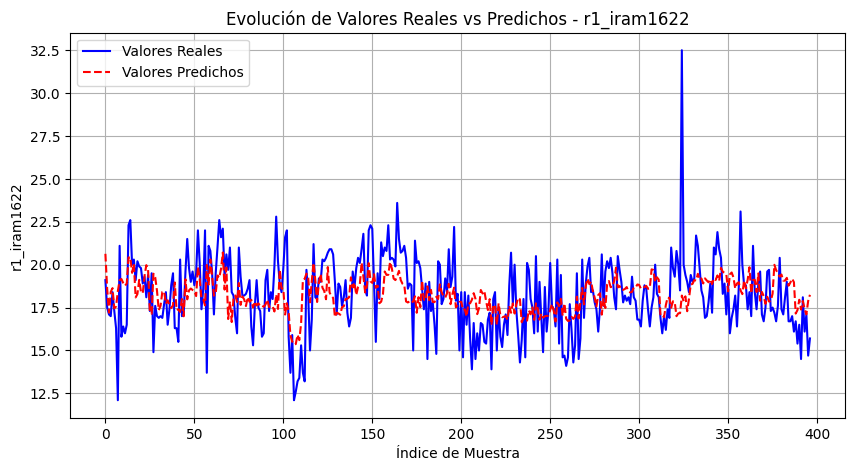

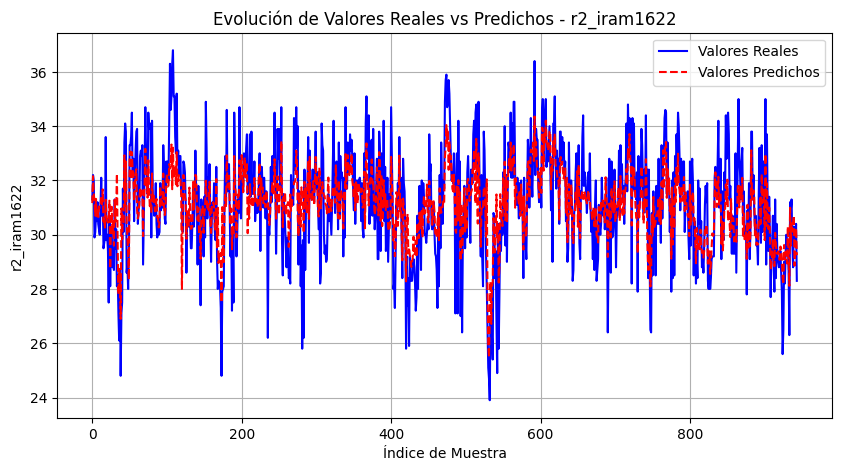

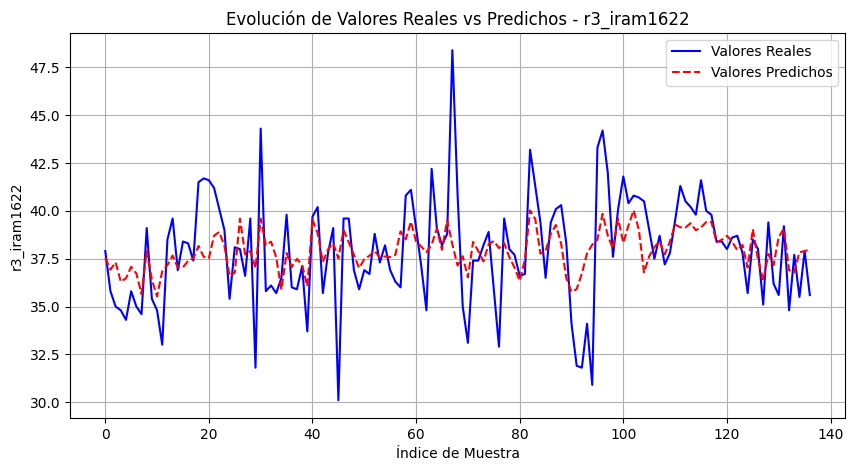

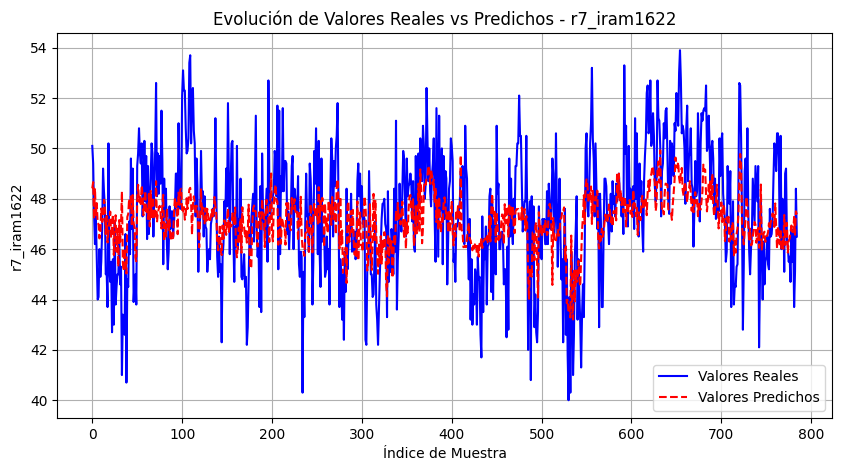

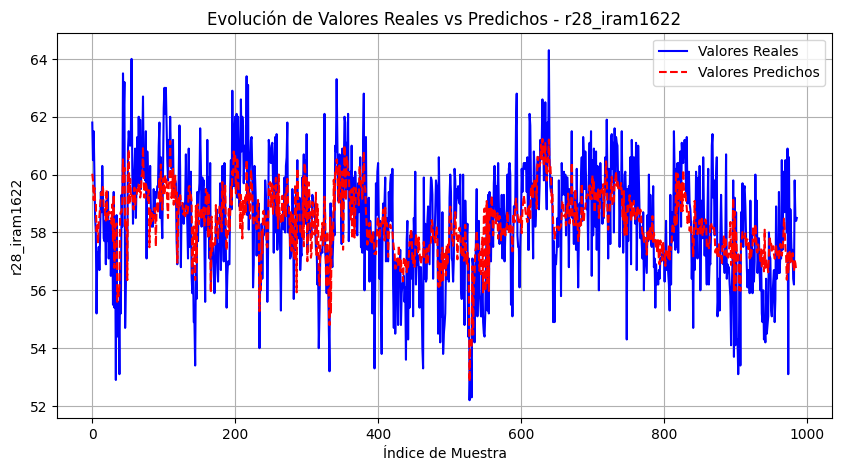

In [30]:

# Crear la carpeta si no existe
carpeta = "graficos del modelo"
if not os.path.exists(carpeta):
    os.makedirs(carpeta)
for col, data in mejores_modelos.items():
    modelo = data["modelo"]

    df_filtrado = df.dropna(subset=[col])
    X = df_filtrado[material_columns]
    y_real = df_filtrado[col]

    X_scaled = scaler.transform(X)
    y_pred = modelo.predict(X_scaled)

    # 🔹 Graficar valores reales y predichos en forma de línea
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(y_real)), y_real, label="Valores Reales", color="blue")
    plt.plot(range(len(y_pred)), y_pred, label="Valores Predichos", color="red", linestyle="dashed")
    plt.xlabel("Índice de Muestra")
    plt.ylabel(col)
    plt.title(f"Evolución de Valores Reales vs Predichos - {col}")
    plt.legend()
    plt.grid(True)
    
        # 📌 Guardar cada imagen con su nombre correspondiente
    ruta_imagen = os.path.join(carpeta, f"grafico_valR_vs_valp{col}.png")
    plt.savefig(ruta_imagen, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()  # Cerrar la figura para liberar memoria


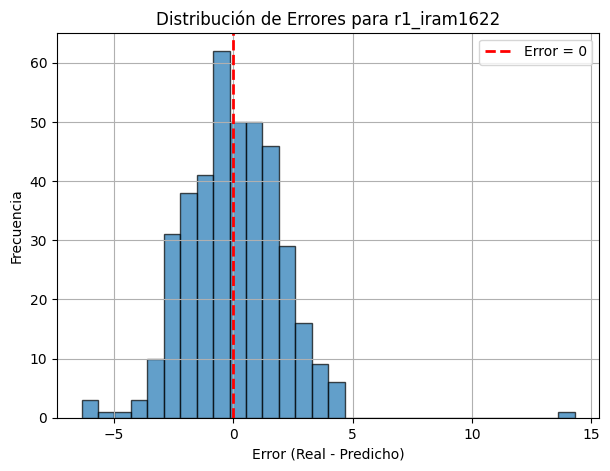

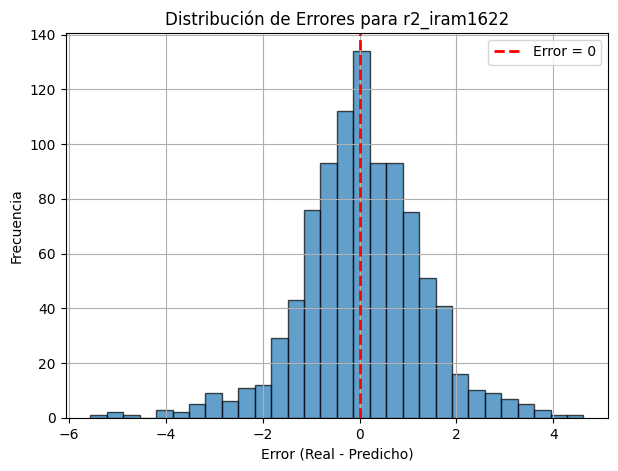

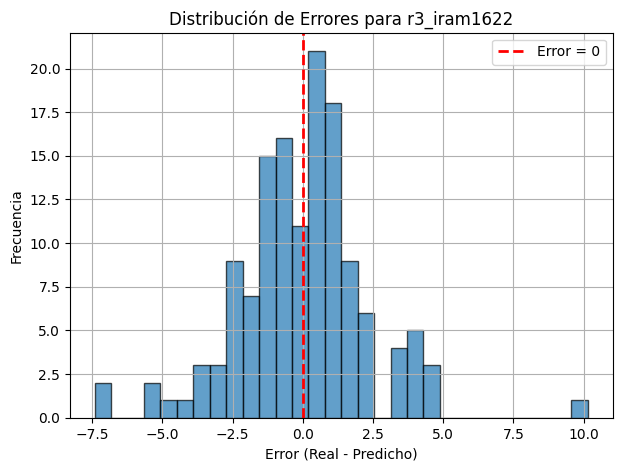

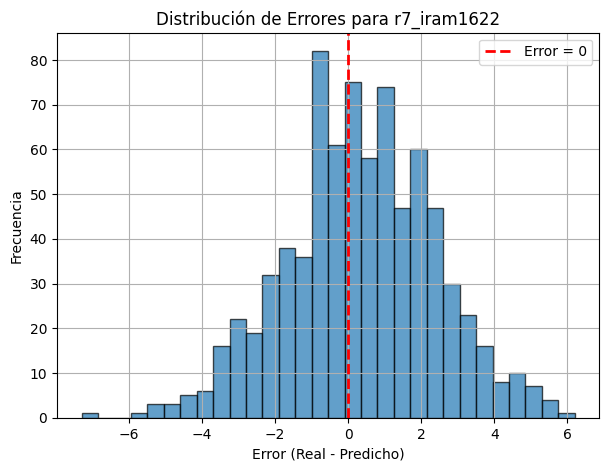

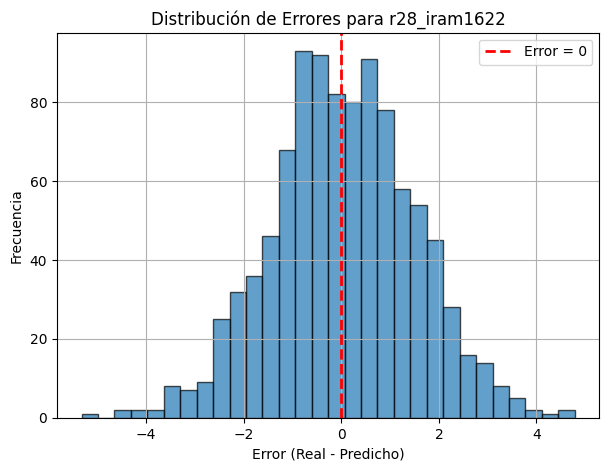

In [32]:
# Crear la carpeta si no existe
carpeta = "graficos del modelo"
if not os.path.exists(carpeta):
    os.makedirs(carpeta)
for col, data in mejores_modelos.items():
    modelo = data["modelo"]

    df_filtrado = df.dropna(subset=[col])
    X = df_filtrado[material_columns]
    y_real = df_filtrado[col]

    X_scaled = scaler.transform(X)
    y_pred = modelo.predict(X_scaled)

    errores = y_real - y_pred  # Diferencia entre valores reales y predichos

    # 🔹 Graficar histograma de errores
    plt.figure(figsize=(7, 5))
    plt.hist(errores, bins=30, edgecolor="black", alpha=0.7)
    plt.axvline(0, color="red", linestyle="dashed", linewidth=2, label="Error = 0")
    plt.xlabel("Error (Real - Predicho)")
    plt.ylabel("Frecuencia")
    plt.title(f"Distribución de Errores para {col}")
    plt.legend()
    plt.grid(True)
            # 📌 Guardar cada imagen con su nombre correspondiente
    ruta_imagen = os.path.join(carpeta, f"1histograma_errores{col}.png")
    plt.savefig(ruta_imagen, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()  # Cerrar la figura para liberar memoria


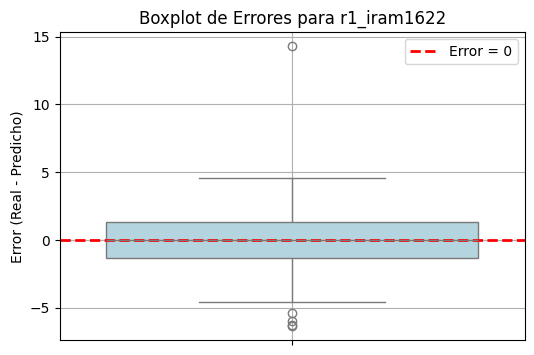

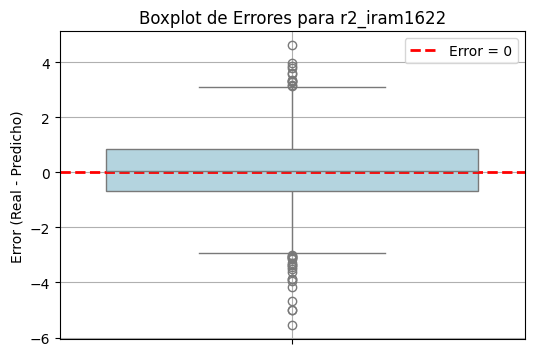

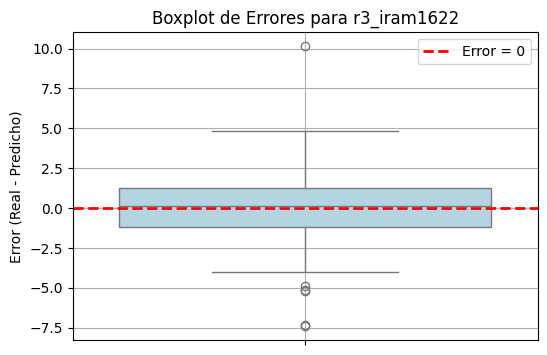

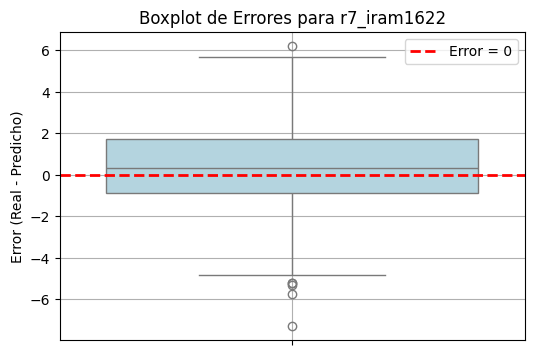

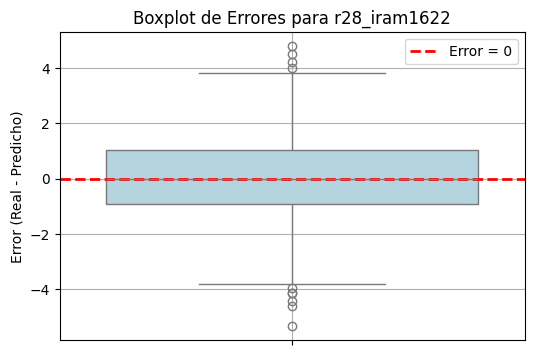

In [13]:
import seaborn as sns

for col, data in mejores_modelos.items():
    modelo = data["modelo"]

    df_filtrado = df.dropna(subset=[col])
    X = df_filtrado[material_columns]
    y_real = df_filtrado[col]

    X_scaled = scaler.transform(X)
    y_pred = modelo.predict(X_scaled)

    errores = y_real - y_pred  

    # 🔹 Graficar boxplot de errores
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=errores, color="lightblue")
    plt.axhline(0, color="red", linestyle="dashed", linewidth=2, label="Error = 0")
    plt.ylabel("Error (Real - Predicho)")
    plt.title(f"Boxplot de Errores para {col}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
import os
import joblib
import json

# 📂 Carpeta donde se guardarán los modelos
carpeta_modelos = "modelos_guardados"
os.makedirs(carpeta_modelos, exist_ok=True)

# Guardar cada modelo con su información
for col, data in mejores_modelos.items():
    modelo = data["modelo"]
    metricas = data["metricas"]

    # 📌 Guardar el modelo con joblib
    nombre_modelo = os.path.join(carpeta_modelos, f"mejor_modelo_{col}.joblib")
    joblib.dump(modelo, nombre_modelo)
    
    # 📌 Guardar las métricas y los hiperparámetros en JSON
    nombre_info = os.path.join(carpeta_modelos, f"info_modelo_{col}.json")
    with open(nombre_info, "w") as f:
        json.dump(metricas, f, indent=4)
    
    print(f"📁 Modelo y métricas guardados: {nombre_modelo} y {nombre_info}")

# Opcional: Guardar el scaler si fue usado
nombre_scaler = os.path.join(carpeta_modelos, "scaler.joblib")
joblib.dump(scaler, nombre_scaler)
print(f"📁 Scaler guardado en: {nombre_scaler}")


📁 Modelo y métricas guardados: modelos_guardados\mejor_modelo_r1_iram1622.joblib y modelos_guardados\info_modelo_r1_iram1622.json
📁 Modelo y métricas guardados: modelos_guardados\mejor_modelo_r2_iram1622.joblib y modelos_guardados\info_modelo_r2_iram1622.json
📁 Modelo y métricas guardados: modelos_guardados\mejor_modelo_r3_iram1622.joblib y modelos_guardados\info_modelo_r3_iram1622.json
📁 Modelo y métricas guardados: modelos_guardados\mejor_modelo_r7_iram1622.joblib y modelos_guardados\info_modelo_r7_iram1622.json
📁 Modelo y métricas guardados: modelos_guardados\mejor_modelo_r28_iram1622.joblib y modelos_guardados\info_modelo_r28_iram1622.json
📁 Scaler guardado en: modelos_guardados\scaler.joblib


KeyError: 'r1_iram1622'

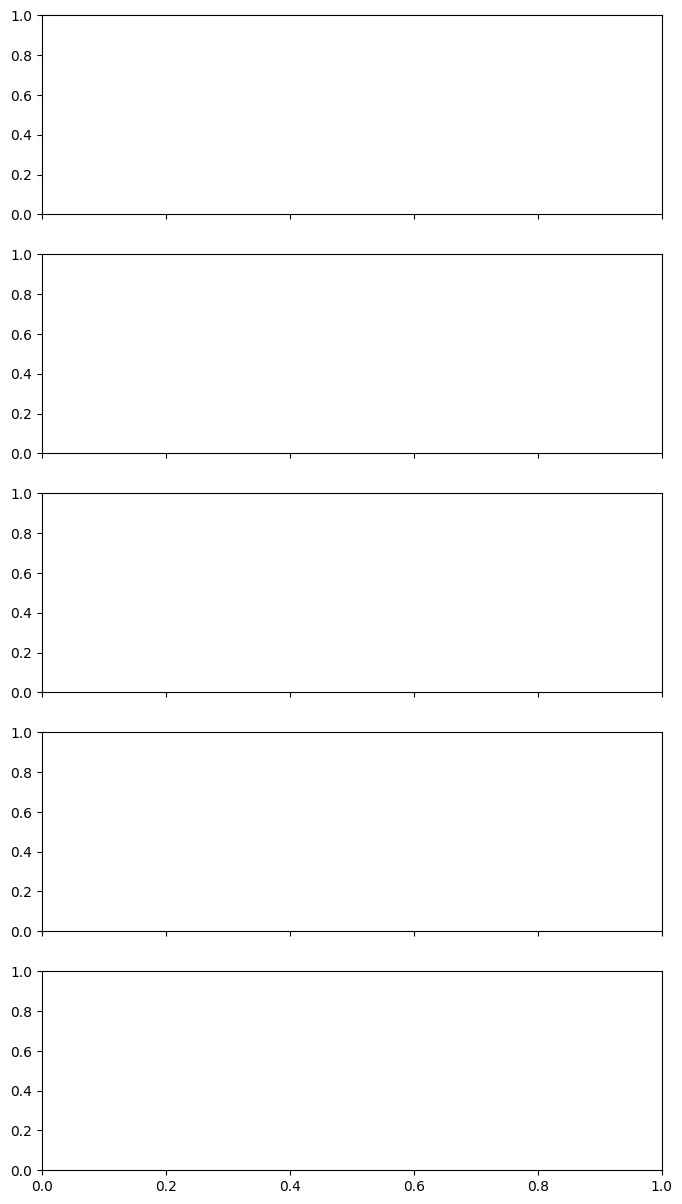

In [19]:

# Diccionario con los MEJORES modelos y sus predicciones


fig, axes = plt.subplots(len(mejores_modelos), 1, figsize=(8, 15), sharex=True)

for i, (dia, (modelo, y_pred)) in enumerate(mejores_modelos.items()):
    residuos = y_real[dia] - y_pred  # Calcular residuos
    
    axes[i].scatter(y_pred, residuos, alpha=0.5, color="blue", edgecolors="black")
    axes[i].axhline(y=0, color='red', linestyle='--', label="Residuo = 0")  # Línea base en 0
    axes[i].set_title(f"{modelo} - {dia}")
    axes[i].set_ylabel("Residuos")
    axes[i].legend()

axes[-1].set_xlabel("Valores Predichos")
plt.tight_layout()
plt.show()